In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import spatialproteomics as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from glob import glob
from tqdm.auto import tqdm
import os

In [2]:
metadata = pd.read_csv("2025-01-28_bnhl_metadata.csv", index_col=0)
entity_class_colors = {'LN': '#9dcbec', 'indolent': '#E2AFAC', 'aggressive': '#741815'}
font_size = 6.5

plt.rcParams.update({"font.size": font_size})  # Adjust the value as needed

In [3]:
formatted_dict = {
    'B cell': 'B cell',
    'B_prol': r'B$_{\mathrm{prol}}$',
    'Dendritic cell': 'Dendritic cell',
    'Endothelial cell': 'Endothelial cell',
    'M2': 'M2',
    'Macrophage': 'Macrophage',
    'Myeloid cell': 'Myeloid cell',
    'Stromal cell': 'Stromal cell',
    'T_fh': r'T$_{\mathrm{fh}}$',
    'T_h': r'T$_{\mathrm{h}}$',
    'T_h_mem': r'T$_{\mathrm{h}}$ mem',
    'T_h_naive': r'T$_{\mathrm{h}}$ naive',
    'T_terminally_exh': r'T$_{\mathrm{term\ exh}}$',
    'T_tox': r'T$_{\mathrm{tox}}$',
    'T_tox_mem': r'T$_{\mathrm{tox}}$ mem',
    'T_tox_naive': r'T$_{\mathrm{tox}}$ naive',
    'T_reg': r'T$_{\mathrm{reg}}$',
    'T_progenitor_exh': r'T$_{\mathrm{prog\ exh}}$',
    'T_reg_Helios': r'T$_{\mathrm{reg}}$ Helios',
    'T cell': 'T cell',
    'T_exh': r'T$_{\mathrm{exh}}$'
}

celltype_order = ['B cell', 'T cell', 'Myeloid cell', 'Dendritic cell', 'Macrophage', 'Stromal cell', 'Endothelial cell']

In [4]:
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests

def compute_anova_results(df):
    results = []
    for ct in df['cell_type'].unique():
        sub_df = df[df['cell_type'] == ct]
        groups = [sub_df[sub_df['entity_class'] == group]['count'].values
                  for group in ['LN', 'indolent', 'aggressive']]
        if all(len(g) > 1 for g in groups):  # Ensure enough data
            f_stat, p_val = f_oneway(*groups)
            results.append({'cell_type': ct, 'p_value': p_val})
        else:
            results.append({'cell_type': ct, 'p_value': 1.0})  # Safe fallback
    results_df = pd.DataFrame(results)

    # Multiple testing correction
    corrected = multipletests(results_df['p_value'], method='fdr_bh')
    results_df['p_value_corrected'] = corrected[1]

    return results_df

In [5]:
def plot_ct_abundance_for_level(level, name, legend=False):
    celltype_abundance_df = pd.read_csv(f"/g/huber/users/meyerben/data/codex/BNHL/ct_abundances/ct_abundances_level_{level}.csv", index_col=0)

    # normalization
    celltype_abundance_df = celltype_abundance_df.div(celltype_abundance_df.sum(axis=1), axis=0)
    
    extra_cols = []
    for i, row in celltype_abundance_df.iterrows():
        patient_id = i

        # Find matching metadata row
        matching_rows = metadata[metadata["Histo-Nr"] == patient_id]

        # Ensure exactly one match is found
        if len(matching_rows) != 1:
            raise ValueError(f"Expected exactly one metadata row for sample_id '{sample_id}', but found {len(matching_rows)}")

        # Get metadata as a dictionary (excluding sample_id_a and sample_id_b)
        metadata_dict = matching_rows.drop(columns=["sample_id_a", "sample_id_b"]).iloc[0].to_dict()

        extra_cols.append([patient_id, metadata_dict['Entity'], metadata_dict['Entity_Class']])

    extra_cols = pd.DataFrame(extra_cols)
    extra_cols.columns = ['patient_id', 'entity', 'entity_class']
    extra_cols['entity_class'] = pd.Categorical(
       extra_cols['entity_class'],
       categories=['LN', 'indolent', 'aggressive'],
       ordered=True  # Optional: Set to True if the categories have an inherent order
    )
    extra_cols.index = celltype_abundance_df.index

    df = pd.concat([extra_cols, celltype_abundance_df], axis=1)
    df = df.melt(
        id_vars=['patient_id', 'entity', 'entity_class'],  # Columns to keep
        var_name='cell_type',  # Name for the new column that will store cell types
        value_name='count'  # Name for the new column that will store the values
    )

    # print(extra_cols['entity'].value_counts())
    # ===== Sample sizes =====
    n_total = extra_cols['patient_id'].nunique()

    n_per_group = (
        extra_cols
        .groupby('entity_class')['patient_id']
        .nunique()
        .to_dict()
    )

    print("Total n =", n_total)
    print("n per group =", n_per_group)


    plt.figure(figsize=(6, 2.5), dpi=600)
    ax = plt.gca()
    sns.boxplot(df, x='cell_type', y='count', hue='entity_class', palette=entity_class_colors, legend=legend, fliersize=3)
    # Remove the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Get and format x-tick labels
    xtick_labels = [label.get_text() for label in ax.get_xticklabels()]
    formatted_labels = [formatted_dict.get(label, label) for label in xtick_labels]
    ax.set_xticklabels(formatted_labels, fontsize=font_size)

    # Set labels with consistent font size
    ax.set_xlabel('')
    ax.set_ylabel(f'Level {level}\nAbundance', fontsize=font_size)
    # rotating the x tick labels
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_horizontalalignment('center')  # or 'left', 'center'
        label.set_verticalalignment('top')  # or 'bottom', 'center'
    # ax.set_title(f'Level {level}', fontsize=font_size)
    
    if legend:
        ax.legend(
            title='',
            loc='upper right',      # Place legend in the top left
            # bbox_to_anchor=(0, 1),  # Adjust position if needed
            fontsize=7,
            frameon=False
        )
        
    # ===== STATISTICAL TESTING =====
    results_df = compute_anova_results(df)
    
    # Make sure cell_type is categorical to preserve consistent order
    df['cell_type'] = pd.Categorical(df['cell_type'], categories=list(celltype_abundance_df.columns), ordered=True)
    df_summary = df.copy()  # Or aggregate if needed
    results_df.to_csv(f'source_data/{name}_source_data.csv')

    # ======= Add ANOVA significance annotations =======
    for idx, cell in enumerate(df_summary['cell_type'].cat.categories):
        try:
            p_val = results_df.loc[results_df['cell_type'] == cell, 'p_value_corrected'].values[0]

            if p_val < 0.001:
                significance = "***"
            elif p_val < 0.01:
                significance = "**"
            elif p_val < 0.05:
                significance = "*"
            else:
                significance = ""

            if significance:
                y_max = df_summary[df_summary['cell_type'] == cell]['count'].max()
                ax.text(
                    idx,  
                    y_max * 1.1,  
                    significance,
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    fontweight='bold',
                    color='black'
                )
        except IndexError:
            print(f"No p-value found for {cell}")
    
    
    plt.tight_layout()
    plt.savefig(f'figures/extended_data_fig_4/{name}.svg', bbox_inches='tight', pad_inches=0)

/tmp/ipykernel_1717/3285157426.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('entity_class')['patient_id']
/tmp/ipykernel_1717/3285157426.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(formatted_labels, fontsize=font_size)


Total n = 132
n per group = {'LN': 29, 'indolent': 61, 'aggressive': 42}


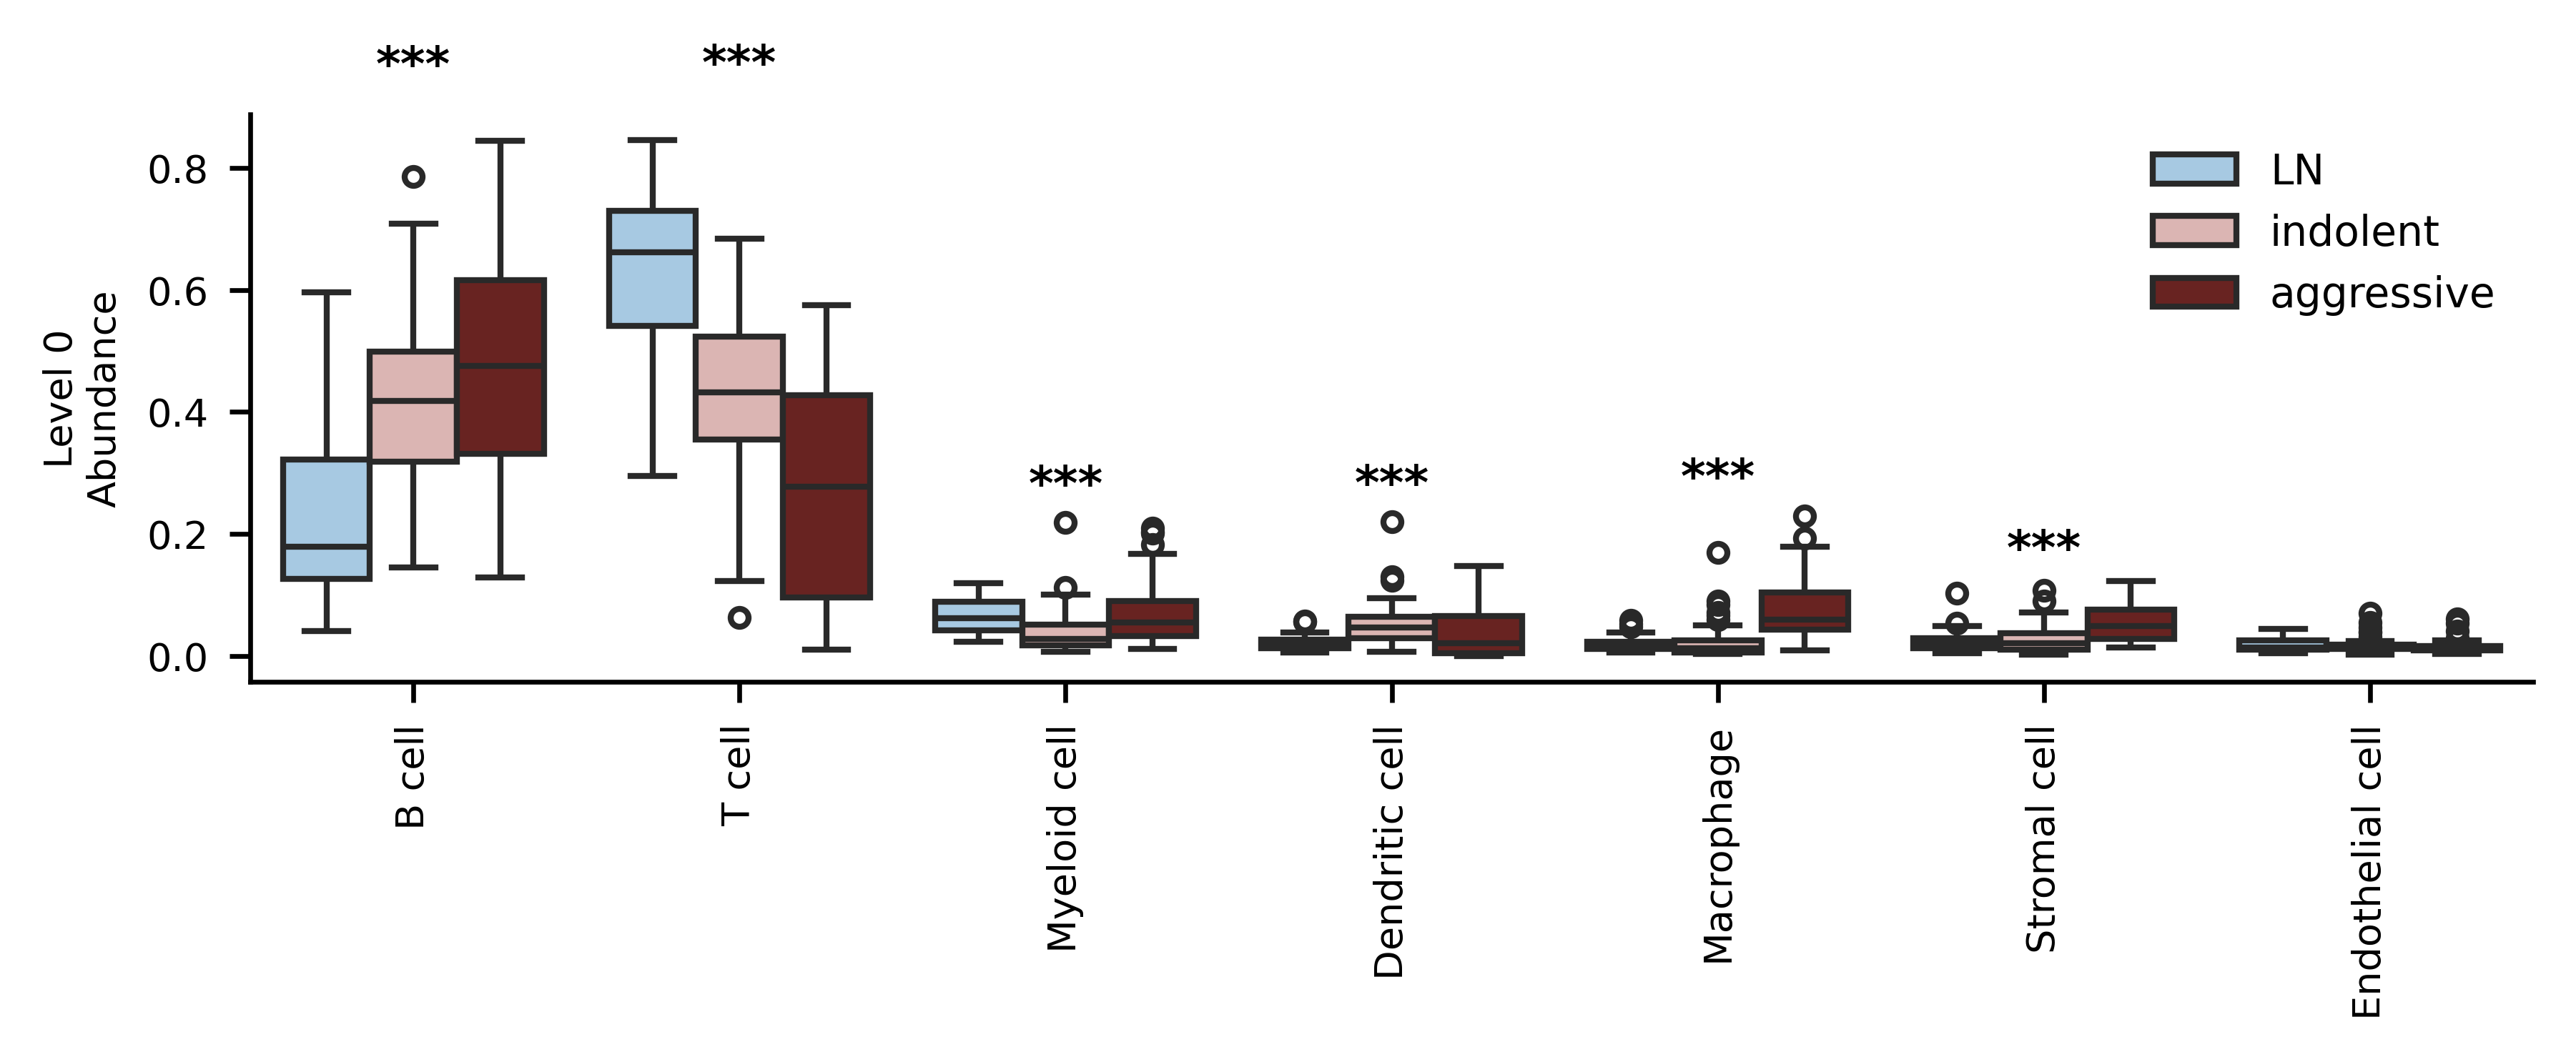

In [6]:
plot_ct_abundance_for_level(0, name='s4a', legend=True)

/tmp/ipykernel_1717/3285157426.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('entity_class')['patient_id']
/tmp/ipykernel_1717/3285157426.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(formatted_labels, fontsize=font_size)


Total n = 132
n per group = {'LN': 29, 'indolent': 61, 'aggressive': 42}


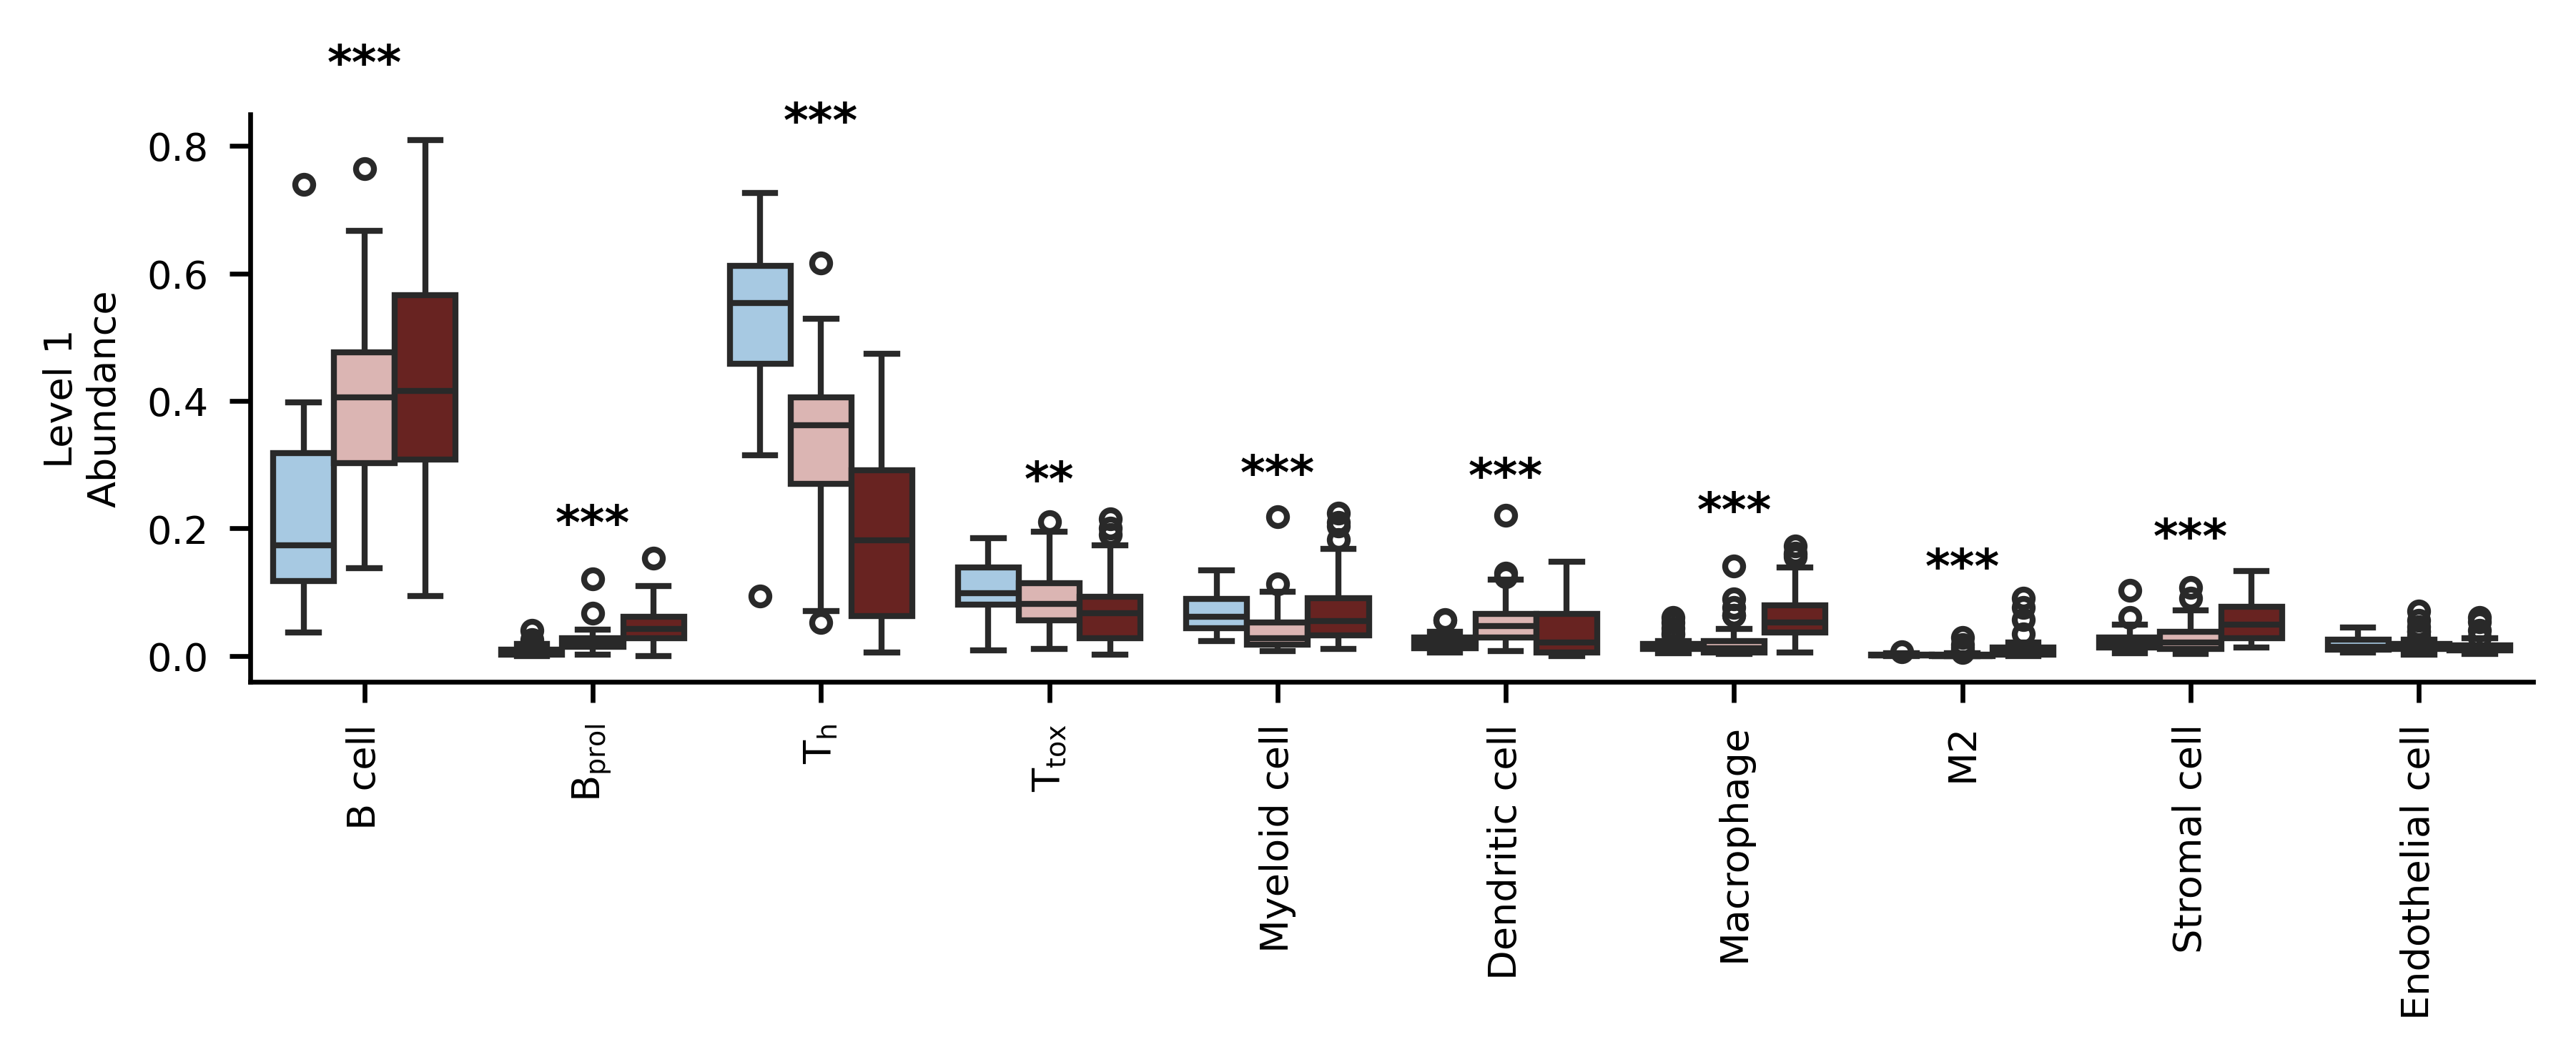

In [7]:
plot_ct_abundance_for_level(1, name='s4b')

/tmp/ipykernel_1717/3285157426.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('entity_class')['patient_id']
/tmp/ipykernel_1717/3285157426.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(formatted_labels, fontsize=font_size)


Total n = 132
n per group = {'LN': 29, 'indolent': 61, 'aggressive': 42}


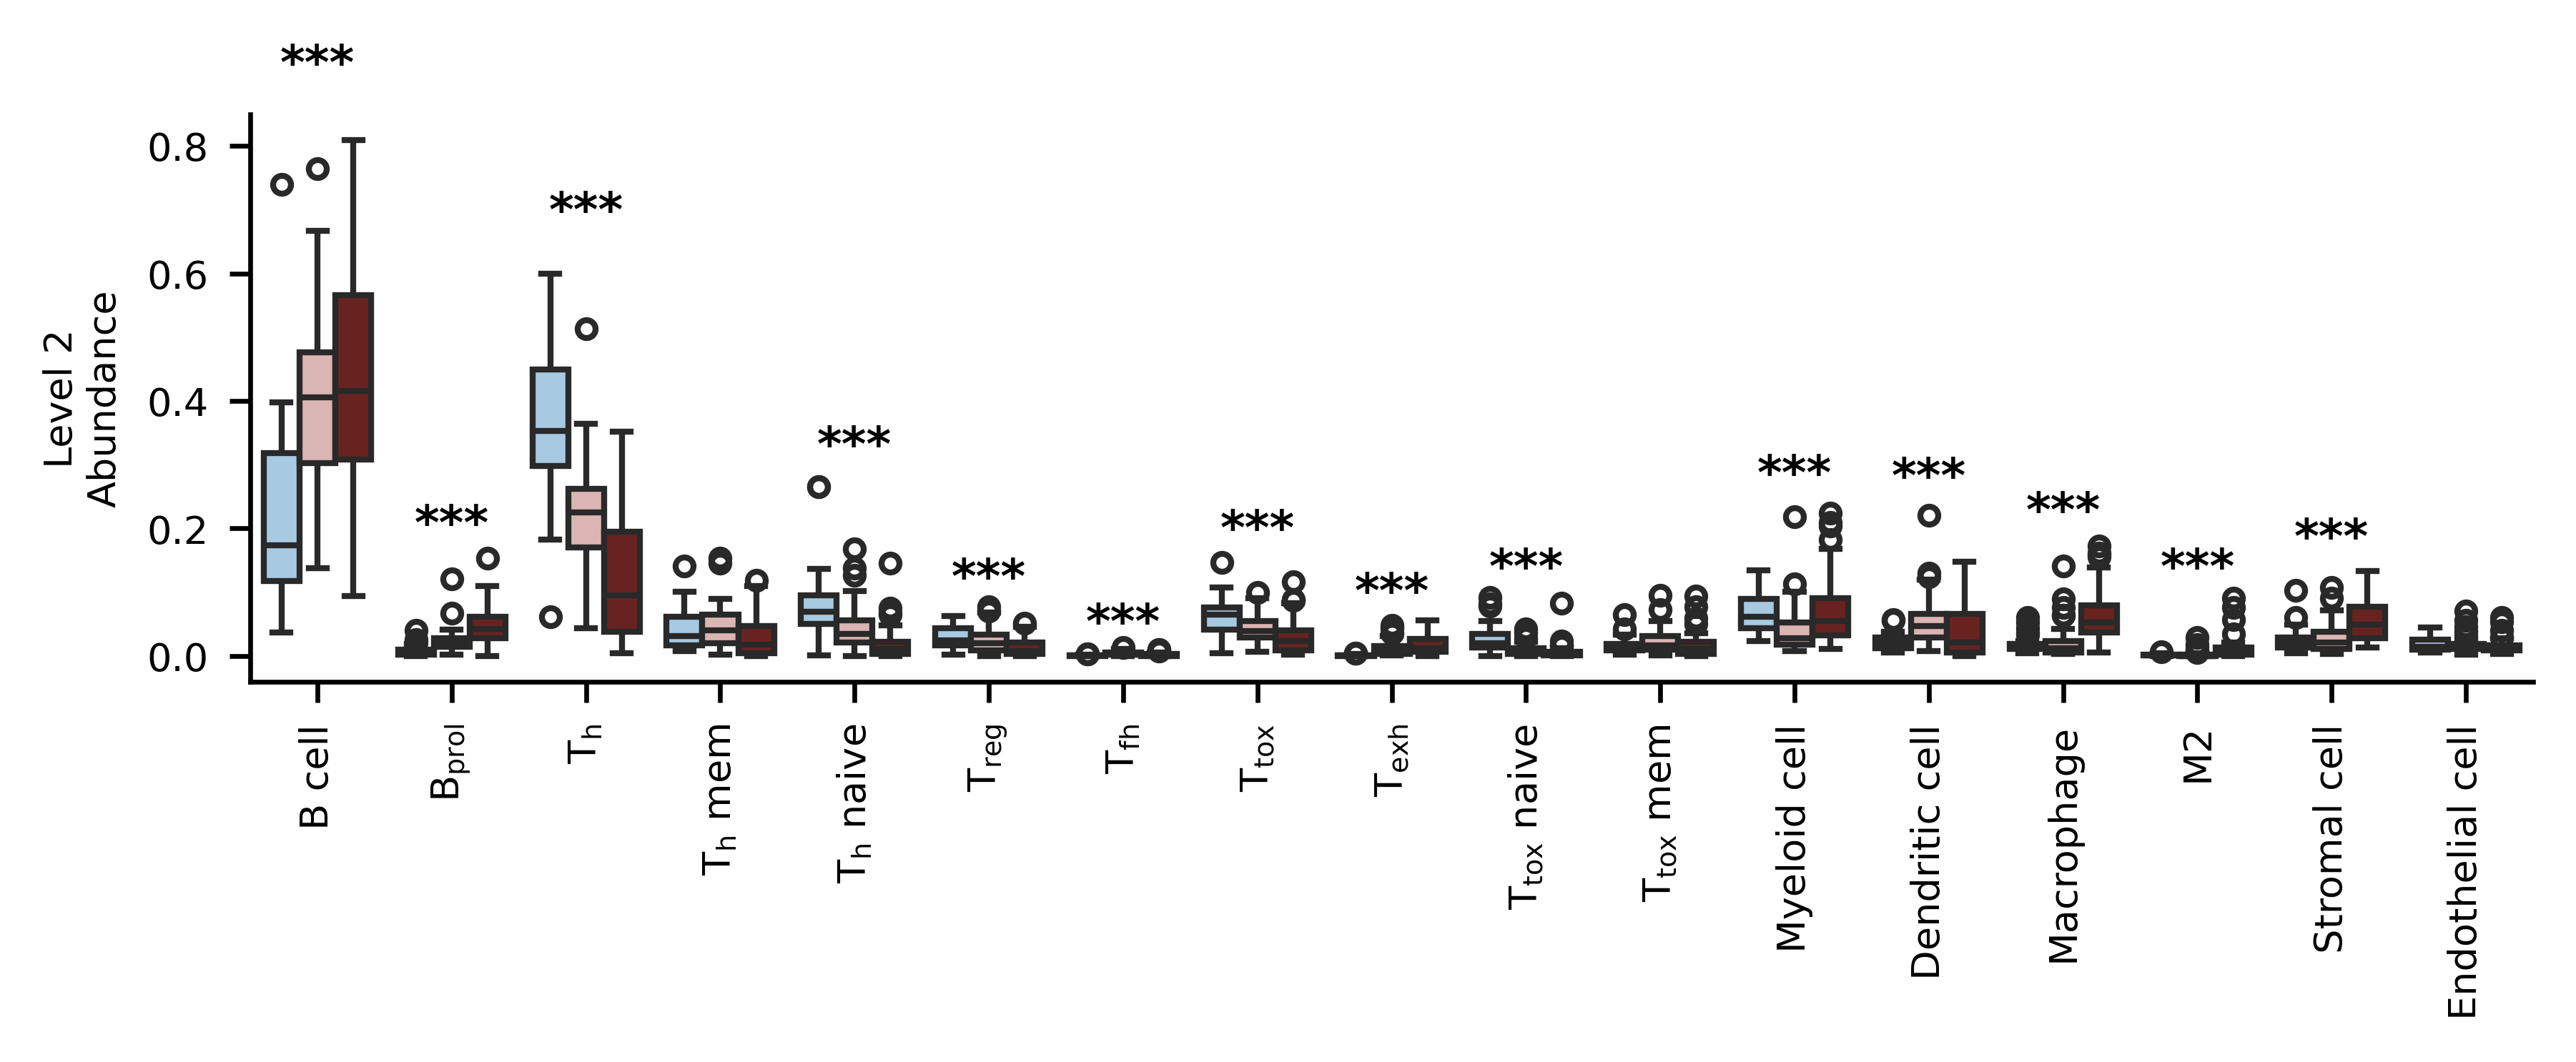

In [8]:
plot_ct_abundance_for_level(2, name='s4c')

/tmp/ipykernel_1717/3285157426.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('entity_class')['patient_id']
/tmp/ipykernel_1717/3285157426.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(formatted_labels, fontsize=font_size)


Total n = 132
n per group = {'LN': 29, 'indolent': 61, 'aggressive': 42}


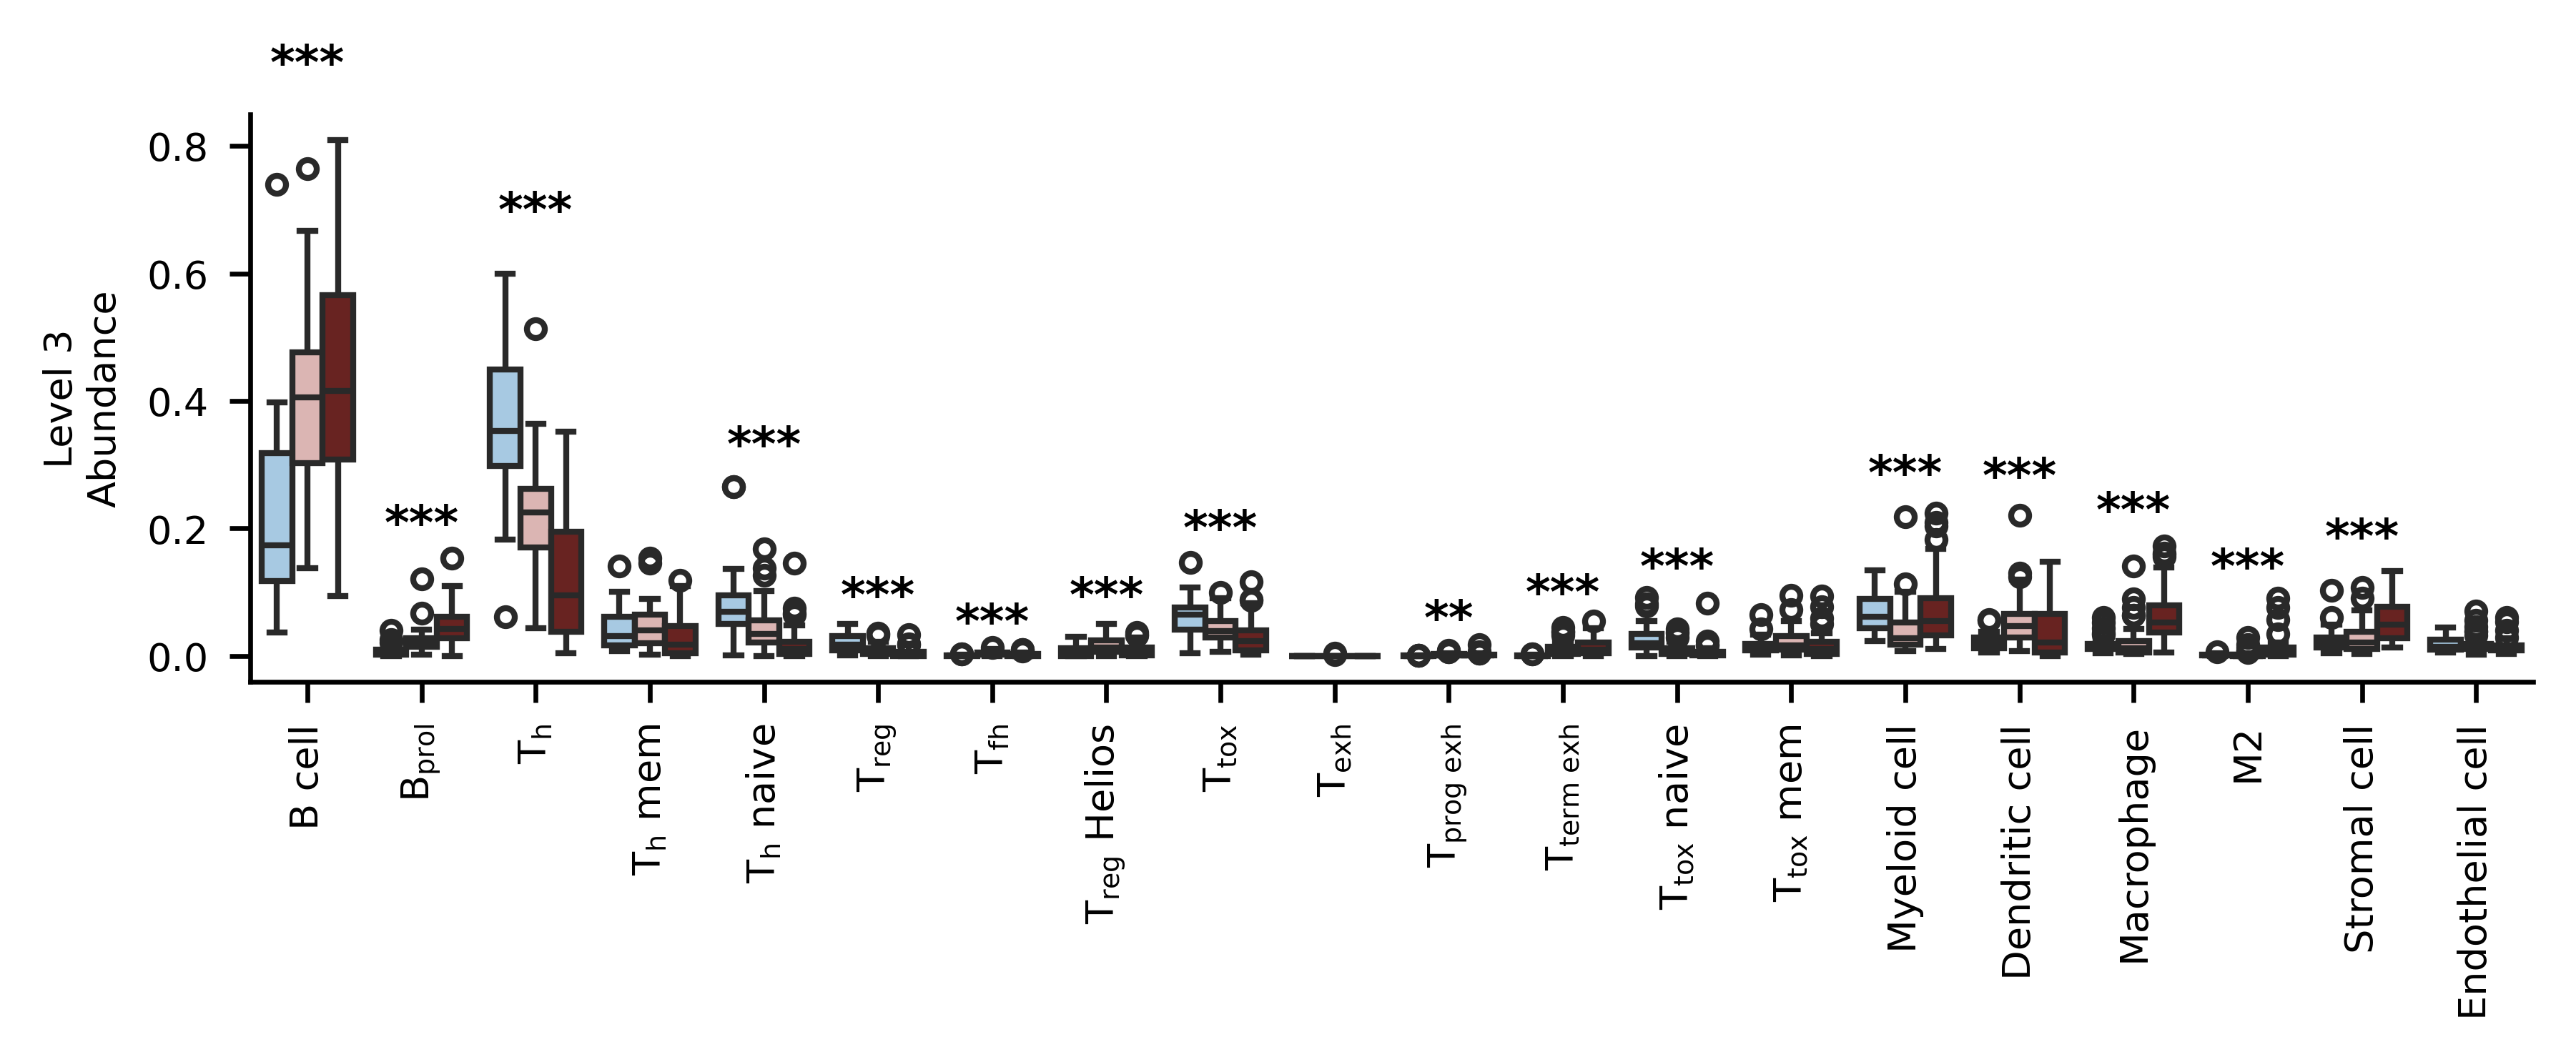

In [9]:
plot_ct_abundance_for_level(3, name='s4d')